# Computer vision problems

Vorige week heb je geleerd hoe je gebruik kan maken van convolutionele lagen om op een efficiente manier classificatie problemen uit te voeren op beelden.
Echter zijn er naast classificatie problemen ook andere zaken die je kan doen in het domein van computer visie.

De meest voorkomende hiervan zijn:
* Object Localization
* Object Detection 
* Image Segmentation

Modellen voor deze oplossingen kunnen zelf gemaakt worden (een oefening hierop gaan we uitvoeren bij image segmentation).
Echter zijn ze vaak heel complex waardoor het vaak eenvoudiger en sneller is om bestaande oplossingen/modellen hiervoor te gebruiken.
Gelukkig zijn er hiervoor een hele reeks te vinden op tensorflow hub.

## Object Localization

Hierbij wordt de regio aangeduid waarin een object gezien wordt.
Dit houdt echter in dat er slechts maar 1 object kan gedetecteerd worden.

Om dit in de praktijk om te zetten gebruiken we een output laag met 4 output neurons.
Deze 4 neurons kunnen dan bijvoorbeeld staan voor:
* xmin van de bounding box
* ymin van de bounding box
* width van de bouding box
* height van de bouding box

Hieronder maken we een voorbeeldmodel die dit doet voor [deze dataset](https://www.kaggle.com/datasets/issaisasank/guns-object-detection):

In [1]:
# BRON: https://www.kaggle.com/code/mayur7garg/guns-object-detection
# imports and download
import os
import glob
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import opendatasets as od

od.download('https://www.kaggle.com/datasets/issaisasank/guns-object-detection')

BASE_IMAGE_PATH = './guns-object-detection/Images'
BASE_LABELS_PATH = './guns-object-detection/Labels'

BATCH_SIZE = 4
EPOCHS = 50
VAL_SPLIT = 0.2
IMG_HEIGHT = 256
IMG_WIDTH = 256

Skipping, found downloaded files in ".\guns-object-detection" (use force=True to force download)


In [2]:
ds = tf.data.Dataset.list_files(BASE_IMAGE_PATH + '/*', seed=123)   # dit is geshuffeled

# splits train en val
image_count = len(ds)
val_size = int(image_count * VAL_SPLIT)
train_ds = ds.skip(val_size)
val_ds = ds.take(val_size)

image_data = []
image_labels = []

image_count = len(os.listdir(BASE_IMAGE_PATH))

for f in train_ds.take(5):
  print(f.numpy())

# get label from path
def get_label(file_path):  
  # Replace the image file extension with .txt to get the label file path
  label_path = tf.strings.regex_replace(file_path, '\\.jpeg$', '.txt')
  label_path = tf.strings.regex_replace(label_path, 'Images', 'Labels')

  label_contents = tf.io.read_file(label_path)
    
  # Split the contents by newline character and get the second line
  lines = tf.strings.split(label_contents, sep='\n')
  second_line = lines[1]
    
  # Split the second line by whitespace and convert to float32
  values = tf.strings.split(second_line, sep=' ')
  values = tf.strings.to_number(values, out_type=tf.float32)
    
  return values

# hoe ga je van path naar tensors
def process_path(file_path):
  label = get_label(file_path)
  # Load the raw data from the file as a string
  img = tf.io.read_file(file_path)
  img = tf.io.decode_jpeg(img, channels=3)
  
  original_height, original_width = tf.shape(img)[0], tf.shape(img)[1]
  label = label * [IMG_WIDTH / original_width, IMG_HEIGHT / original_height, IMG_WIDTH / original_width, IMG_HEIGHT / original_height]
    
  return tf.image.resize(img, [IMG_HEIGHT, IMG_WIDTH]), label

# Set `num_parallel_calls` so multiple images are loaded/processed in parallel.
train_ds = train_ds.map(process_path, num_parallel_calls=tf.data.AUTOTUNE)
val_ds = val_ds.map(process_path, num_parallel_calls=tf.data.AUTOTUNE)

def configure_for_performance(ds):
  ds = ds.cache()
  ds = ds.shuffle(buffer_size=1000)
  ds = ds.batch(BATCH_SIZE)
  ds = ds.prefetch(buffer_size=tf.data.AUTOTUNE)
  return ds

train_ds = configure_for_performance(train_ds)
val_ds = configure_for_performance(val_ds)

b'.\\guns-object-detection\\Images\\214.jpeg'
b'.\\guns-object-detection\\Images\\4.jpeg'
b'.\\guns-object-detection\\Images\\122.jpeg'
b'.\\guns-object-detection\\Images\\3.jpeg'
b'.\\guns-object-detection\\Images\\12.jpeg'


(256, 256, 3) (4,)


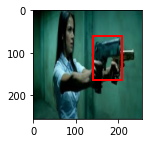

(256, 256, 3) (4,)


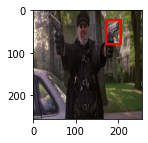

(256, 256, 3) (4,)


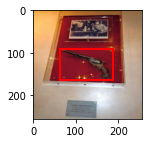

(256, 256, 3) (4,)


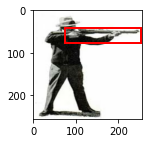

In [3]:
def plot_images_with_boxes(ds, batch_number=0, predictions=None):
    # Get the batch data
    img_batch, label_batch = next(iter(ds.skip(batch_number).take(1)))

    for i in range(BATCH_SIZE):
        img = img_batch[i]
        label = label_batch[i]

        # Convert TensorFlow tensors to NumPy arrays
        img = img.numpy() / 255.
        label = label.numpy()
        print(img.shape, label.shape)
        
        # Create a figure and axis for plotting
        fig, ax = plt.subplots(1, figsize=(2, 2))
        
        # Plot the image
        ax.imshow(img)
        
        # Extract and plot boxes (labels)
        x1, y1, x2, y2 = label
        rect = plt.Rectangle((x1, y1),x2-x1, y2-y1, linewidth=2, edgecolor='r', facecolor='none')
        ax.add_patch(rect)
        
        # Plot predictions if available
        if predictions is not None:
            pred = predictions[i+ batch_number*BATCH_SIZE]
            x1, y1, x2, y2 = pred
            rect = plt.Rectangle((x1, y1),x2-x1, y2-y1, linewidth=2, edgecolor='g', facecolor='none')
            ax.add_patch(rect)
        
        plt.show()

plot_images_with_boxes(train_ds, 0)

In [4]:
# make segmentation model
filename='gun_detection.h5' # h5 is typisch eeen extensie voor keras modellen

if os.path.exists(filename):
    model = tf.keras.models.load_model(filename)
else:
    model = tf.keras.models.Sequential([
        tf.keras.layers.Rescaling(1./255),

        # convolutioneel gedeelte
        tf.keras.layers.Conv2D(6, 3, padding='same', input_shape=(IMG_HEIGHT, IMG_WIDTH, 3), activation='relu'),
        tf.keras.layers.MaxPooling2D(),
        tf.keras.layers.Conv2D(16, 3, padding='same', activation='relu'),
        tf.keras.layers.MaxPooling2D(),
        tf.keras.layers.Conv2D(32, 3, padding='same', activation='relu'),
        tf.keras.layers.MaxPooling2D(),

        # verbinding tussen convolutioneel gedeelte en fully connected
        tf.keras.layers.Flatten(),
        # fully connected gedeelte
        tf.keras.layers.Dense(units=100, activation='relu'),
        tf.keras.layers.Dense(4, activation='linear')
    ])

    model.compile(optimizer='adam', loss='mae')

    history=model.fit(train_ds, epochs=20, validation_data = val_ds)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])

    model.save(filename)


Epoch 1/20
67/67 [==============================] - 9s 120ms/step - loss: 56.6519 - val_loss: 48.4733
Epoch 2/20
67/67 [==============================] - 8s 115ms/step - loss: 45.2999 - val_loss: 42.8306
Epoch 3/20
67/67 [==============================] - 8s 116ms/step - loss: 40.5769 - val_loss: 38.8035
Epoch 4/20
67/67 [==============================] - 8s 114ms/step - loss: 40.7931 - val_loss: 41.4083
Epoch 5/20
67/67 [==============================] - 8s 117ms/step - loss: 38.9044 - val_loss: 37.1505
Epoch 6/20
67/67 [==============================] - 9s 136ms/step - loss: 38.3297 - val_loss: 37.5374
Epoch 7/20
67/67 [==============================] - 10s 149ms/step - loss: 36.2586 - val_loss: 36.6232
Epoch 8/20
67/67 [==============================] - 9s 139ms/step - loss: 35.6903 - val_loss: 37.4750
Epoch 9/20
67/67 [==============================] - 10s 147ms/step - loss: 35.7915 - val_loss: 35.9417
Epoch 10/20
67/67 [==============================] - 10s 150ms/step - loss: 35.2

In [ ]:
batch_number = 3
predictions_train = model.predict(train_ds)
predictions_val = model.predict(val_ds)

plot_images_with_boxes(train_ds, batch_number, predictions_train)
plot_images_with_boxes(val_ds, batch_number, predictions_val)


## Object Detection

Object detectie is een uitbreiding van object localization waarbij geprobeerd wordt alle objecten in een figuur te detecteren en classificeren.
Er zijn doorheen de jaren een hele reeks neurale netwerken getrained voor verschillende inputs/classes/snelheden/... 
Een overzicht hiervan kan je vinden op [deze link](https://tfhub.dev/tensorflow/collections/object_detection/1)

Dit is vaak te complex en te inefficient om op je eigen laptop te trainen en het is veel eenvoudiger om hiervoor bestaande modellen te gebruiken.
**Het is zelfs zo dat meestal dit soort modellen ook gebruikt worden voor object localization op te lossen vanwege de eenvoud van deze modellen**.

Hoe je een bestaand model kan gebruiken gaan we volgende week zien maar kan je al een proefje van krijgen door de demo-code te bekijken.

# Image segmentation

Een uitbreiding op object detectie is dat we gaan kijken voor elke pixel of groep pixels tot welke klasse het behoort.
Ook hiervoor bestaan er een reeks bestaande netwerken op tensorflow hub, zie [deze link](https://tfhub.dev/s?module-type=image-segmentation).

Let op dat het Mask R-CNN model hier niet tussen staat omdat het technisch gezien object detectie doet maar de resultaten kunnen ook gebruikt worden voor image segmentation.
Opnieuw verwijs ik naar volgende week voor het uitvoeren van de image segmentation met bestaande netwerken.

Hieronder staat er echter voorbeeldcode hoe je het ook zelf kan doen.

In [ ]:
od.download("https://www.kaggle.com/datasets/devdgohil/the-oxfordiiit-pet-dataset")

Er zijn twee folders gedownload. 
De folder images bevat alle figuren in de dataset waarbij de naam van de file begint met de klasse waartoe het behoort.
De folder annotations is iets complexer en bevat segmentation masks voor elke figuur in de trimaps folder en extra metadata voor elke figuur in de xmls file.
Deze metadata bevat bijvoorbeeld informatie over de bounding boxes van de dieren in de figuren.
In dit deel gaan we enkel werken met de informatie uit de trimaps folder om het model te trainen.

In [ ]:
input_dir = "the-oxfordiiit-pet-dataset/images/images"
target_dir = "the-oxfordiiit-pet-dataset/annotations/annotations/trimaps"

input_img_paths = sorted([os.path.join(input_dir,fname) for fname in os.listdir(input_dir) if fname.endswith(".jpg")])
target_paths = sorted([os.path.join(target_dir,fname) for fname in os.listdir(target_dir) if fname.endswith(".png") and not fname.startswith(".")])

print("Num inputs: ", len(input_img_paths))
print("Num targets: ", len(target_paths))

In [ ]:
# show some input images
fig = plt.figure(figsize=(16, 4))
columns = 8
rows = 2
for i in range(1, columns*rows +1):
    img = tf.keras.utils.load_img(input_img_paths[i+100])
    fig.add_subplot(rows, columns, i)
    plt.axis("off")
    plt.imshow(img)
plt.show()

In [ ]:
# show some target images
fig = plt.figure(figsize=(16, 4))
for i in range(1, columns*rows +1):
    img = tf.keras.utils.img_to_array(tf.keras.utils.load_img(target_paths[i+100], color_mode = "grayscale"))
    plt.axis("off")
    fig.add_subplot(rows, columns, i)
    normalized_array = (img.astype("uint8")-1)*127
    plt.axis("off")
    plt.imshow(normalized_array[:,:,0])
    
plt.show()

In [ ]:
# Maak datasets aan

BASE_IMAGE_PATH = ".\\the-oxfordiiit-pet-dataset\\images\\images"
BASE_LABEL_PATH = ".\\the-oxfordiiit-pet-dataset\\annotations/annotations\\trimaps"
BATCH_SIZE = 64

ds = tf.data.Dataset.list_files(BASE_IMAGE_PATH + '/*.jpg', seed=123)   # dit is geshuffeled

# splits train en val
image_count = len(ds)
val_size = int(image_count * VAL_SPLIT)
train_ds = ds.skip(val_size)
val_ds = ds.take(val_size)

image_data = []
image_labels = []

image_count = len(os.listdir(BASE_IMAGE_PATH))

for f in train_ds.take(5):
  print(f.numpy())

# get label from path
def get_label(file_path):  
  # Replace the image file extension with .txt to get the label file path    
  filename = tf.strings.split(file_path, os.path.sep)[-1]
  filename = tf.strings.regex_replace(filename, '.jpg', '.png')


  target = tf.io.read_file(BASE_LABEL_PATH + "\\" + filename)
  target =  tf.io.decode_png(target)
  target = tf.image.resize(target, [IMG_HEIGHT, IMG_WIDTH], method = tf.image.ResizeMethod.NEAREST_NEIGHBOR)
  target = target - 1     # labels zijn 1-2-3 -> doe -1 zodat het begint vanaf 0
  return target

# lees img from file
def decode_img(img):

  img = tf.io.read_file(img) 
  img = tf.io.decode_jpeg(img, channels=3)
  return tf.image.resize(img, [IMG_HEIGHT, IMG_WIDTH])

# hoe ga je van path naar tensors
def process_path(file_path):
  return decode_img(file_path), get_label(file_path)

# Set `num_parallel_calls` so multiple images are loaded/processed in parallel.
train_ds = train_ds.map(process_path, num_parallel_calls=tf.data.AUTOTUNE)
val_ds = val_ds.map(process_path, num_parallel_calls=tf.data.AUTOTUNE)

def configure_for_performance(ds):
  ds = ds.cache()
  ds = ds.shuffle(buffer_size=1000)
  ds = ds.batch(BATCH_SIZE)
  ds = ds.prefetch(buffer_size=tf.data.AUTOTUNE)
  return ds

train_ds = configure_for_performance(train_ds)
val_ds = configure_for_performance(val_ds)

In [ ]:
def plot_images_with_segmentations(ds, batch_number=0, num_figures=4, predictions=None):
    # Get the batch data
    img_batch, label_batch = next(iter(ds.skip(batch_number).take(1)))
    
    num_cols = 2 if predictions is None else 3

    fig, axs = plt.subplots(num_figures, num_cols, figsize=(3 * num_cols, 3 * num_figures))
        
    for i in range(num_figures):
        img = img_batch[i]
        label = label_batch[i]

        # Convert TensorFlow tensors to NumPy arrays
        img = img.numpy() / 255.
        label = label.numpy()
        
        # Plot the image
        axs[i, 0].imshow(img)
        
        # Plot the label
        axs[i, 1].imshow(label)
        
        # Plot predictions if available
        if predictions is not None:
            pred = predictions[i+ batch_number*BATCH_SIZE]
            pred = tf.math.argmax(pred, axis=-1)
            pred = pred[..., tf.newaxis]
            axs[i, 2].imshow(pred)
        
    plt.show()

plot_images_with_segmentations(train_ds, batch_number=0, num_figures=4)

In [ ]:
# image segmentation model (U-net)inputs = Input(shape=input_shape)
input_shape=(256, 256, 3)
num_classes = 3
inputs = tf.keras.layers.Input(shape=input_shape)

# Encoder
conv1 = tf.keras.layers.Conv2D(64, 3, activation='relu', padding='same')(inputs)
conv1 = tf.keras.layers.Conv2D(64, 3, activation='relu', padding='same')(conv1)
pool1 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(conv1)

conv2 = tf.keras.layers.Conv2D(128, 3, activation='relu', padding='same')(pool1)
conv2 = tf.keras.layers.Conv2D(128, 3, activation='relu', padding='same')(conv2)
pool2 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(conv2)

conv3 = tf.keras.layers.Conv2D(256, 3, activation='relu', padding='same')(pool2)
conv3 = tf.keras.layers.Conv2D(256, 3, activation='relu', padding='same')(conv3)
pool3 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(conv3)

# Bottleneck
conv4 = tf.keras.layers.Conv2D(512, 3, activation='relu', padding='same')(pool3)
conv4 = tf.keras.layers.Conv2D(512, 3, activation='relu', padding='same')(conv4)

# Decoder
up5 = tf.keras.layers.UpSampling2D(size=(2, 2))(conv4)
up5 = tf.keras.layers.Concatenate(axis=-1)([up5, conv3])
conv5 = tf.keras.layers.Conv2D(256, 3, activation='relu', padding='same')(up5)
conv5 = tf.keras.layers.Conv2D(256, 3, activation='relu', padding='same')(conv5)

up6 = tf.keras.layers.UpSampling2D(size=(2, 2))(conv5)
up6 = tf.keras.layers.Concatenate(axis=-1)([up6, conv2])
conv6 = tf.keras.layers.Conv2D(128, 3, activation='relu', padding='same')(up6)
conv6 = tf.keras.layers.Conv2D(128, 3, activation='relu', padding='same')(conv6)

up7 = tf.keras.layers.UpSampling2D(size=(2, 2))(conv6)
up7 = tf.keras.layers.Concatenate(axis=-1)([up7, conv1])
conv7 = tf.keras.layers.Conv2D(64, 3, activation='relu', padding='same')(up7)
conv7 = tf.keras.layers.Conv2D(64, 3, activation='relu', padding='same')(conv7)

# Output layer
output = tf.keras.layers.Conv2D(num_classes, 1, activation='softmax')(conv7)        # waarom softmax? per pixel heb je 3 klassen -> vandaar ook 3 kernels

model = tf.keras.models.Model(inputs=inputs, outputs=output)

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])  # categorical cross entropy -> output as one-hot, label as idx of best

tf.keras.utils.plot_model(model, show_shapes=True)

In [ ]:
checkpoint_file = 'catdog_segmentation.h5'

if os.path.exists(checkpoint_file):
    model = tf.keras.models.load_model(checkpoint_file)
else:
  history = model.fit(train_ds, epochs=1, validation_data=val_ds.take(1))

  model.save(checkpoint_file)

  loss = history.history['loss']
  val_loss = history.history['val_loss']

  plt.figure()
  plt.plot(history.epoch, loss, 'r', label='Training loss')
  plt.plot(history.epoch, val_loss, 'bo', label='Validation loss')
  plt.title('Training and Validation Loss')
  plt.xlabel('Epoch')
  plt.ylabel('Loss Value')
  plt.ylim([0, 1])
  plt.legend()
  plt.show()  

In [ ]:
predictions = model.predict(val_ds.take(3))

In [ ]:
plot_images_with_segmentations(val_ds, batch_number=0, num_figures=4, predictions=predictions)
